In [1]:
# Standard library
import os
import shutil
import io
import re
import warnings
from datetime import datetime
import pytz
import string

# Third-party
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Spark and GCP
import pyspark
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.conf import SparkConf
from google.cloud import storage

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [5]:
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [6]:
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

### Read Data

In [7]:
tweets_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified')

23/03/10 18:52:36 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
num_rows = tweets_df.count()

### Data

In [9]:
# Max and min dates
min_date, max_date = tweets_df.select(f.min('tweet_date'), f.max('tweet_date')).first()
min_date, max_date

(datetime.datetime(2022, 4, 5, 4, 21, 36),
 datetime.datetime(2023, 2, 8, 13, 10, 37))

In [10]:
max_date - min_date

datetime.timedelta(days=309, seconds=31741)

In [11]:
# Remove duplicates 
tweets_df = tweets_df.dropDuplicates(['tweet_id'])

In [12]:
num_rows - tweets_df.count()

1104

## Daily Frequency

In [ ]:
tweets_df.limit(10)

user_description,user_favourites_count,user_followers_count,user_friends_count,user_id,user_name,user_protected,user_screen_name,user_statuses_count,user_verified,user_withheld_in_countries,user_location,tweet_date,retweeted_status,is_retweet,is_reply,tweet_id,retweeted_from,tweet_text,quoted_status,hashtags,tweet_coordinates,retweet_count,retweeted_from_name,retweeted_from_description,Category
i dont say much ...,15938,63,98,21122746,Wizard of Hope,false,Jolliger,12013,false,[],UK,2022-04-05 04:37:14,"{null, Mon Apr 04...",true,false,1511201271616790528,richimedhurst,ive invited addre...,null,[],null,170,Richard Medhurst,independent journ...,Other
name is a note to me,32682,86,575,279385706,Squirrel!Watchthe...,false,mysqrlfeed,3081,false,[],null,2022-04-05 05:08:00,null,false,true,1511209012200620034,null,shepmjs handful m...,null,[],null,null,null,null,Other
am adventurou...,11185,390,796,1477960242847756290,Fudribo Henry,false,FudriboH,2137,false,[],Arua,2022-04-05 05:09:56,"{null, Tue Apr 05...",true,false,1511209498970673152,Parliament_Ug,rt hon jacob oula...,null,[],null,5,Parliament of Uganda,parliament derive...,Other
rapper script wri...,30534,909,638,1433339738178588676,Prekyjay1,false,Prekyjay11,17223,false,[],null,2022-04-05 05:13:19,"{null, Tue Apr 05...",true,false,1511210353299968001,migosi_brian,dedan kimathi uni...,null,[],null,10,Migosi,politics and law ...,Other
fashion designer,444,313,160,1432857084224286725,Jeenz,false,sardagoddess,5003,false,[],null,2022-04-05 05:18:56,"{null, Sun Apr 03...",true,false,1511211764020649986,GenXerAlex,make 40k year col...,null,[],null,6744,Revolution🖖🏾,twitter where po...,Other
passionate about ...,1595,153,542,1499695930433486853,Nyebesa Isaac,false,NyebesaI,2081,false,[],null,2022-04-05 05:28:49,"{null, Tue Apr 05...",true,false,1511214253063036929,Parliament_Ug,rt hon jacob oula...,null,[],null,10,Parliament of Uganda,parliament derive...,Other
,4350,30,130,730323135870939137,"NIT,💱",false,Nitya1212,1496,false,[],भारत बर्ष,2022-04-05 05:40:17,"{null, Mon Apr 04...",true,false,1511217137540468736,pchavhanke,education upbring...,null,[],null,3531,Pradosh Chavhanke,deputy editor y...,Other
northern enthusia...,9876,666,1019,14722858,John Keith Sibbald,false,jsibbald,3795,false,[],Manchester. England,2022-04-05 05:40:53,"{null, Mon Apr 04...",true,false,1511217290276130816,RealGeoffBarton,school amp colleg...,null,[],null,30,Geoff Barton,general secretary...,Other
...,37112,711,1977,282659021,गणेश परब,false,artganesh1973,16427,false,[],Mumbai,2022-04-05 05:41:57,"{null, Mon Apr 04...",true,false,1511217557868781570,pchavhanke,education upbring...,null,[],null,3536,Pradosh Chavhanke,deputy editor y...,Other
account 6 7 co...,257,92,391,1511030137894092801,THE VOICE 🎙️CHRI...,false,THEVOICECHRIST6,425,false,[],♥️ of 🇺🇸 TIFFAN...,2022-04-05 06:22:30,null,false,true,1511227764627714053,null,godstrojanhorse s...,null,[],null,null,null,null,Other


In [13]:
dates_df = tweets_df.select('user_name', 'user_description', 'tweet_text', 'tweet_id', 'tweet_date', 'user_location','Category')

In [14]:
dates_df

user_name,user_description,tweet_text,tweet_id,tweet_date,user_location,Category
BBW Lover,virgo just he...,make 40k year col...,1511198211939225605,2022-04-05 04:25:05,City of Townsville,Other
Daniel Drake,princeton 24 ...,living butler col...,1511198993627467778,2022-04-05 04:28:11,"Washington, USA",Other
jerry bunton,null,marychaostyle far...,1511199077656150019,2022-04-05 04:28:31,null,Other
jacob || #EN_READS,en re...,enchanted sunsun ...,1511200276069650434,2022-04-05 04:33:17,he him ; 🔞 ...,Other
certi*!+.thefound...,18,tittiesonice keyo...,1511200389554704389,2022-04-05 04:33:44,she/her,Other
Wizard of Hope,i dont say much ...,ive invited addre...,1511201271616790528,2022-04-05 04:37:14,UK,Other
Greg Bluestein,husband father ...,gt speakerralston...,1511203364784291842,2022-04-05 04:45:33,ATL,News
Amrendra Kumar Lal,teacher husband ...,education upbring...,1511205001175048195,2022-04-05 04:52:03,"Madhubani, India",Other
Wes Fang,the nsw parliamen...,gathering evidenc...,1511206416035442691,2022-04-05 04:57:41,"Wagga Wagga, NSW",Other
Squirrel!Watchthe...,name is a note to me,shepmjs handful m...,1511209012200620034,2022-04-05 05:08:00,null,Other


In [14]:
by_day = (dates_df.withColumn('year', f.year('tweet_date'))
                  .withColumn('month', f.month('tweet_date'))
                  .withColumn('day', f.dayofmonth('tweet_date'))
                  .groupby(['year', 'month', 'day'])
                  .agg(f.count('tweet_id').alias('count'),
                       f.max('user_name').alias('user_name'),
                       f.max('user_description').alias('user_description'),
                       f.max('tweet_text').alias('tweet_text'),
                       f.max('Category').alias('Category'),
                       f.max('user_location').alias('user_location'))
                  .withColumn('date', f.concat_ws('-', *['year', 'month', 'day']).cast('date'))
                  .select(['user_name','user_description','tweet_text','date', 'count','Category','user_location'])
                  .toPandas())
by_day

,user_name,user_description,tweet_text,date,count,Category,user_location
0,🫶🏾🧘🏾‍♀️,zust ndig f r kindertagesbetreuung beim parit tischen gesamtverband views my own,zubairyounas009 hi abu sufyan lahore living narowal nd im student linguistics university narowal,2022-04-30,45287,Other,🪴 any pronouns !
1,🫶🏽☆ gabariela ☆ 🎄,zzz,zzzzwriter socdoneleft learning basic college level concepts hs happy youre getting better education students america upset gave students challenge,2022-05-02,49412,Other,🫶EARTH.
2,🫶🏾,zzzzzzzzzzzzzzz,zyyyyzyyyyzyyyy dwell humiliating ignorance education getting college diploma education unrelenting pursuit truth whatever takes wherever leads,2022-05-10,53998,Other,🫶🏻
3,🫶🏽,zwillingsbruder von wiederdaichbin noch schlechter drauf hoflieferant von premiumhass ich trinke nicht ich bin das b se,zylath51 andnodumbthings capritheunruly actual history meaning lies high school history teacher told,2022-05-15,34828,Other,🫀
4,󠛡 󠛡 󠛡 󠛡 󠛡,zxxxz,zuzana skvarkova spring 2022 outstanding undergraduate school future innovation society graduation plans become physician continue work disability rights activist asugrad,2022-05-17,48512,Other,🪐
...,...,...,...,...,...,...,...
305,🫶🏾,zustin zarry jelena srk replied,zyyan ali yar wo kn c university ha namal jo free education day rahe please let know thanks,2022-11-18,37441,Other,🫧 | 18 | she/her | scb gc
306,🫶🏻,zyniker sarkasmus selbstbestimmung freidenker i want to believe 17 bewegung ist alles mental und physisch,zxvgdeqwju ly prep school jerks college nft,2023-01-10,35635,Other,🪹
307,🫶🏾,zulu van damme orlando pirates ft liverpool and real madrid my backup account thulanimjiyako,zytegirl govrondesantis flsert misinformed entire departments universities dedicated african american studies think going college making money afterward youre wrong college education period,2023-01-21,37185,Other,🪬
308,🫶🏽🌘E. Rivers🌒🌎🧢,zz,zz university make college dreams come true alexisfawx xbaileybrookex dannydxxx,2023-01-30,39130,Other,🫵💀


In [15]:
# Convert date column to datetime
by_day.date = pd.to_datetime(by_day.date)
by_day.sort_values(by='date', ascending=True, inplace=True)
by_day

,user_name,user_description,tweet_text,date,count,Category,user_location
258,🫶🏻 — shuhua !!,zzzzzz,zxsaturn think projection falsified school board make fake claim parents concerned otherkin idiots school board filled snowflake boomers think otherkin furries,2022-04-05,34452,Other,🪐
112,🫶🏼,zoraki partizan phd maas neotek alumni,zupergurl1 exactly today lost spot university master degree cause forgot today payment day taken months even get accepted university first place,2022-04-06,49073,Other,🫰💎🇵🇭
293,🫶 | freetag,zxcvbnm,zzzzzzzzhaha aspt army school physical training abbotabad allow civilians courses,2022-04-07,47970,Other,🫶
220,🫧Wandering.haazeee🫧,zyite is a digital media provider,zzzzzeinabaufer nope maybe 5 6 yrs old dont even cheat exams men would cheat nombu went school fasting however one time monitor schl teacher planned field trip asked muslim classmates come,2022-04-08,38551,Other,🪐🪐
221,🫧꒰ఎ𝓚໒꒱🫧,zyite is a digital media provider,zugenia nkoyenkoyenkoye oxunipress ugh sorry gena dispicable publishing decision teaching post phd mostly analyzing academic sources undergrads amp university presses usually reliable sources oup positive example guess theyre great example thats always true,2022-04-09,31228,Other,🧸
...,...,...,...,...,...,...,...
36,🫶🏾,zzzzz zzzz zz z,zvoutete14 sparta 1000 daddyhope rmajongwe omasaraure reality ground kids rural areas engaged form work help family think way end gvt introduces monetary incentive keep children school form school allowance per child every month,2023-02-04,38216,Other,🫶🏻
292,🫶🏾🪬☮️,zurda ling ista y hierbera incan heritage educator,zyreion 9 youre invited hbcu hs football showcase camp livingstone college saturday may 20th 27th 2023 lots college coaches divisions attendance scan qr code flyer register click,2023-02-05,28523,Other,🦎+⏳
309,🫶🏽⚖️,zoophiles taking ls homophobic taking ls bad people taking ls since valid ls and tranphobicls are bad people heres a non problematic account,zzindoriyamz hi one fortes im graduating college student state univ amp knowledgeable kind task let know details rate negotiable dm start,2023-02-06,34971,Other,🫀
37,🫶🏽🫶🏽🫶🏽,zulu girl with some swag,zyhiela hey forte 3rd year law student major literature highest gwa 1 16 amp consistent president lister polytechnic university philippines kindly pm swift transactions,2023-02-07,42782,Other,🫧𝟏𝟖 𝐲𝐨 𝐬𝐡𝐞/𝐡𝐞𝐫🫧


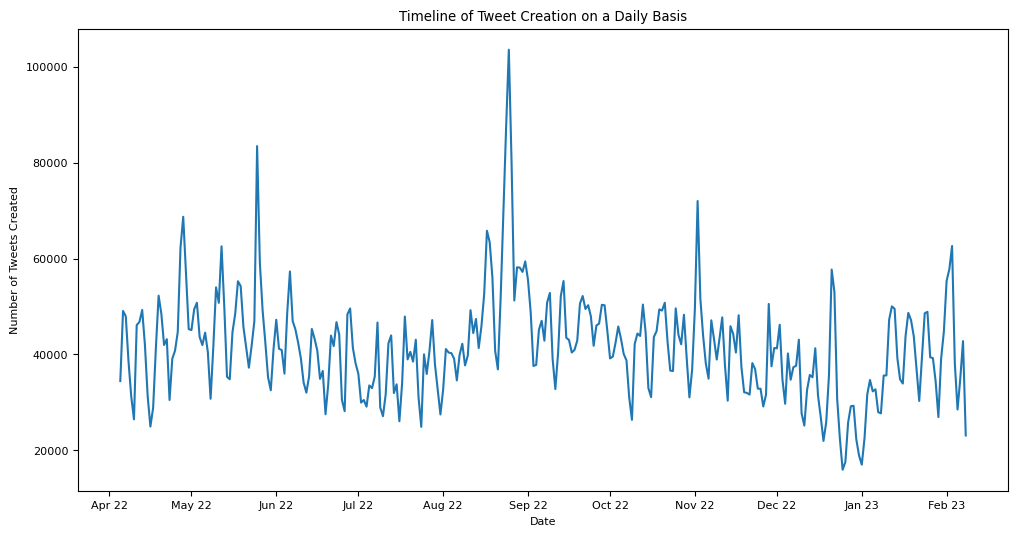

In [16]:
# Plot
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots()
ax.plot(by_day['date'], by_day['count'])

ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets Created')
ax.set_title('Timeline of Tweet Creation on a Daily Basis')

# Format and change intervals of x axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

plt.show()

In [16]:
by_day.sort_values(by='count', ascending=False, inplace=True)

In [17]:
by_day

,user_name,user_description,tweet_text,date,count,Category,user_location
199,🫶🏻,zyite is an electronics and powered transport retailer,zzzbeeme mklgriffth piper4missouri matter bc one generation know fix anything trades abandoned bc everyone thinks college education necessary,2022-08-25,103537,Other,🫠
87,🫶🏾🫧,zzzzz,zzyxxyzz preferred frame would look jobs require education high school universities refuse provide wonder unpopular w state legislatures,2022-08-24,87177,Other,🫶 ➡️ 🍂🍄🫐☕️🧋❄️⛈🎧📚
5,🫶🏾sweetie boy,zzz thinking about harry styles and chris evans,zzzbongwater like least college could learn shit high school,2022-05-25,83439,Other,🫧… she / her 16 read carrd
200,🫵🏾,zzz dont wake up the kitten,zz university make college dreams come true register today alexisfawx xbaileybrookex dannydxxx,2022-08-26,80059,Other,🫧
246,🫶🏾,zzzzzzz,zypher755 universities lost track narrative culturally push education dominated society time time education precursor career holds benefit beyond anymore increasing majority,2022-11-02,71991,Other,🫶🏾 lovers lane.
...,...,...,...,...,...,...,...
216,🫧🖤🕸,zweitaccount von eu sciencegeek jetzt auch unter twitterhasstdiewahrheit teambiologie teamrealit t teildesproblems,zweivan ryanatdust2 go back school learn please,2022-12-18,21975,Other,🪐🍩
104,🫶🏾🎂,zz,zuma legacy zuma built two sol plaatje university university mpumalanga someone mention collapsing eskom later dreamt smart city,2022-12-31,18920,Other,🫶
285,🫰🏻 𝕷é𝖆𝖓𝖉𝖗𝖔𝖘 𝕻𝖆𝖈𝖎𝖋𝖎𝖈𝖔 ♓,zululands premier shopping destination a sheer majesty of comparative shopping established retail development,zza aless cooldamxbone school didnt expell frank according dont want scandal like scandal would expelling poor kid like ishya cause school like school invaded armed men ishaya everything swept rug haba,2022-12-26,17573,Other,🪐
32,🫧 👄 T .,zwe man city gafa open minded no to violence,zvaediotbodo babak90819191 thenamibian assumptions results product teacher learner school government input terms resources education sector would know,2023-01-01,17023,Other,🪐


In [21]:
dates_df.filter((f.col('tweet_date')>= '2022-08-25 00:00:00') & (f.col('tweet_date')<= '2022-08-25 11:59:59')).toPandas()

,user_name,user_description,tweet_text,tweet_id,tweet_date,user_location,Category
0,Lori Mechelle,waiting for the world to come along wife mom daughter genx don t assume you know me righttoself stem equality or bust,thinks poor people want kids get college education taxes already pay republicans want keep tax dollars decide among give left wants give tax dollars back people right goes ballistic,1562591170588393472,2022-08-25 00:02:21,None,Other
1,This Grimace is Tall,all about a real safety net for all peoples and the planet would rather be building free housing refugee raised everything through those lens,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1562591174719725569,2022-08-25 00:02:22,None,Other
2,Hylen S,i like to read,remind folks posted 1960 could pay full year university minnesota six weeks minimum wage job student debt consequence systematic defunding higher education bad borrower decisions cancelstudentdebt,1562591382258085888,2022-08-25 00:03:11,California,Other
3,drjulieo,psychologist for the underserved mother partner gardener believer in human rights,hawleymo might well return campus missouri university see actually taught reportedly attended several years university training youre trying appeal good old boys pretending arent part liar,1562591558897045506,2022-08-25 00:03:53,"Missouri, USA",Other
4,Tammy Regen,wife mom kidney transplant survivor lymphoma survivor former rn no dms i will block trump trolls rt s follows endorsement,floridian never thought school boards red blue give damn care one thing children learn highest potential want school board members qualified experienced whose priority teaching children well period,1562591593705910273,2022-08-25 00:04:02,"Knoxville, TN",Other
...,...,...,...,...,...,...,...
44387,Kathy Dee,jewelry designer world traveler lover of democracy the orange nightmare is out of our house barry blitt illustration no dms no dms resist blm,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1562769858668171265,2022-08-25 11:52:23,"Chicago, IL",Other
44388,Bill Fenstermaker,husband daddy in lebanon pa deconstructivist nosey know it all on the net not a big fan of events or ceremony,problem w debt cancellation long overdue year jubilee wonder implications impacts student loan cancellation may future loans amp may head toward free college plans love dad hs senior thoughts kairyssdal,1562770606050795522,2022-08-25 11:55:22,"Lebanon, PA",Other
44389,Ndagije Richard,amooti certified digital content creator by bbcworld arsenal own opinions g o a t moves digital 360 nextmediaug patience is key,university leaders stakeholders students among others attending makerereat100 lecture organized makerere officialmubs follow proceedings live,1562770814864596993,2022-08-25 11:56:11,"0.3476° N, 32.5825° E",News
44390,Adrian Parsons,created this account so i can be an old man yelling at a cloud is it working,since today cancelstudentdebt announcement tease obsessed inflation calculator boomers sense money value mom made 13k year public school art teacher 1972 paltry right may shocked see today us dollars,1562770823605534720,2022-08-25 11:56:13,"Toronto, Ontario",Other


In [18]:
dates_df.filter(f.col('tweet_date').rlike('2022-08-25')).toPandas()

,user_name,user_description,tweet_text,tweet_id,tweet_date,user_location,Category
0,Lori Mechelle,waiting for the world to come along wife mom daughter genx don t assume you know me righttoself stem equality or bust,thinks poor people want kids get college education taxes already pay republicans want keep tax dollars decide among give left wants give tax dollars back people right goes ballistic,1562591170588393472,2022-08-25 00:02:21,None,Other
1,This Grimace is Tall,all about a real safety net for all peoples and the planet would rather be building free housing refugee raised everything through those lens,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1562591174719725569,2022-08-25 00:02:22,None,Other
2,Hylen S,i like to read,remind folks posted 1960 could pay full year university minnesota six weeks minimum wage job student debt consequence systematic defunding higher education bad borrower decisions cancelstudentdebt,1562591382258085888,2022-08-25 00:03:11,California,Other
3,drjulieo,psychologist for the underserved mother partner gardener believer in human rights,hawleymo might well return campus missouri university see actually taught reportedly attended several years university training youre trying appeal good old boys pretending arent part liar,1562591558897045506,2022-08-25 00:03:53,"Missouri, USA",Other
4,Tammy Regen,wife mom kidney transplant survivor lymphoma survivor former rn no dms i will block trump trolls rt s follows endorsement,floridian never thought school boards red blue give damn care one thing children learn highest potential want school board members qualified experienced whose priority teaching children well period,1562591593705910273,2022-08-25 00:04:02,"Knoxville, TN",Other
...,...,...,...,...,...,...,...
103532,Roxy 🧢,None,fyi mitch mcconnell went university louisville tuition 330,1562948045960261633,2022-08-25 23:40:26,United States,Other
103533,Free Two-BearArms,god guns guts made this country great rvn infantry combat vet buckeye airborne,many universities engaging ultimate form price gouging raise tuition every year sitting non taxable multi billion dollar endowments keep long government keeps giving young kids blank check college loans,1562949172898058241,2022-08-25 23:44:55,None,Other
103534,Rob Pharr,None,much student debt leftwing universities keep raising tuition graduating kids worthless degrees thats solution student debt doesnt touch billions dollars sitting university endowments absolute scam,1562950800728801281,2022-08-25 23:51:23,None,Other
103535,Paige Lover,paige wrestling fan posting ss of combos with the ironsheik go fuck yourself tweets making aew stains cry just by my handle pfp name and existing,translation listen student loans bad drop youre still high school like,1562950917984464896,2022-08-25 23:51:51,None,Other


In [18]:
topic = '(joe biden|biden|cancel|student debt|eligible|low income)'

In [19]:
peak = dates_df.filter(f.col('tweet_date').rlike('2022-08-25'))

In [23]:
peak.filter(f.col('tweet_text').rlike(topic)).toPandas()

,user_name,user_description,tweet_text,tweet_id,tweet_date,user_location,Category
0,This Grimace is Tall,all about a real safety net for all peoples and the planet would rather be building free housing refugee raised everything through those lens,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1562591174719725569,2022-08-25 00:02:22,None,Other
1,Hylen S,i like to read,remind folks posted 1960 could pay full year university minnesota six weeks minimum wage job student debt consequence systematic defunding higher education bad borrower decisions cancelstudentdebt,1562591382258085888,2022-08-25 00:03:11,California,Other
2,Observations &,advocate for those less fortunate end human trafficking blm protect women s voting rights save ukraine married af bicycle fetish lover,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1562591622176849924,2022-08-25 00:04:08,"Ohio, USA",Other
3,StiflersDad 🇺🇸🌌,genx wired different legacy4kids crypto btc eth ada doge tsla robotaxi 1776 easternnc i am a free speech absolutist elonmus,hardworking american pay lazy sniveling spoiled brat trust fund baby college tuition buy iphones macbooks 15 double fudge lattes starbucks refusing get job biden america,1562591701335650310,2022-08-25 00:04:27,None,Other
4,John Thomas,marine corps combat veteran love my country conservative maga trump supporter day one christian married 46 y to my best friend i follow back trumper maga,much student debt leftwing universities keep raising tuition graduating kids worthless degrees thats solution student debt doesnt touch billions dollars sitting university endowments absolute scam,1562592174788661248,2022-08-25 00:06:20,Louisiana,Other
...,...,...,...,...,...,...,...
27281,Matthew Brewer,hs science teacher father of 4 beautiful children finalist 2014 washington toy lets learn something new together waedu edchat he him,worked butt get scholarships college worked hard pay loans couldnt happier potus cancelling student debt hope cancels even education free edchat,1562935718154215424,2022-08-25 22:51:27,"Ephrata, WA",Other
27282,Ashley Richards,nothin,let counter bullshit republican talking point right retweet college debt happy people getting help student debt,1562937887045337088,2022-08-25 23:00:04,None,Other
27283,Matty Brown,screenwriter musician expert at repairing and restoring vintage everything,unfair force truck driver pay loan someone got phd gender studies taxpayers footing bill student loan relief biden order constitutional anything universities handing worthless degrees hook,1562938261836017664,2022-08-25 23:01:34,None,Other
27284,Thinkin’ Outloud,soccer football,glad wasted years life military afford going college biden could come along pay student loan debts worthless college kids hate america,1562939945949753344,2022-08-25 23:08:15,None,Other


In [22]:
peak.filter(f.col('tweet_text').rlike(topic)).count()

27286

In [24]:
peak.filter(~f.col('tweet_text').rlike(topic)).toPandas()

,user_name,user_description,tweet_text,tweet_id,tweet_date,user_location,Category
0,Lori Mechelle,waiting for the world to come along wife mom daughter genx don t assume you know me righttoself stem equality or bust,thinks poor people want kids get college education taxes already pay republicans want keep tax dollars decide among give left wants give tax dollars back people right goes ballistic,1562591170588393472,2022-08-25 00:02:21,None,Other
1,drjulieo,psychologist for the underserved mother partner gardener believer in human rights,hawleymo might well return campus missouri university see actually taught reportedly attended several years university training youre trying appeal good old boys pretending arent part liar,1562591558897045506,2022-08-25 00:03:53,"Missouri, USA",Other
2,Tammy Regen,wife mom kidney transplant survivor lymphoma survivor former rn no dms i will block trump trolls rt s follows endorsement,floridian never thought school boards red blue give damn care one thing children learn highest potential want school board members qualified experienced whose priority teaching children well period,1562591593705910273,2022-08-25 00:04:02,"Knoxville, TN",Other
3,mktsutherland,passionate curious gardens art travel politics theresistance,started thinking make users people online resilient misinformation new research university researchers google confirms promising approach epidemic online misinformation,1562591664664825856,2022-08-25 00:04:19,"St Paul, MN",Other
4,loey | ia 📚,012 treasure maker,would lower standard matter hard idol junghwan still manage attend different school activities go school everyday works overtime treasuremembers,1562592142694166528,2022-08-25 00:06:13,travis & sam.,Other
...,...,...,...,...,...,...,...
76246,"Estarianne, Public Intellectual 👩🏼‍💻",human rights disability antifascism progressive politics inclusive feminism psychology and neuroscience birds medicareforall adhd,cdave77 kornelwest palmerwood52 whitehouse indeed public universities dont want reform youve got finger pulse higher education know much professor makes every year average public research university,1562947575442853888,2022-08-25 23:38:34,🍊 California,Other
76247,Roxy 🧢,None,fyi mitch mcconnell went university louisville tuition 330,1562948045960261633,2022-08-25 23:40:26,United States,Other
76248,Free Two-BearArms,god guns guts made this country great rvn infantry combat vet buckeye airborne,many universities engaging ultimate form price gouging raise tuition every year sitting non taxable multi billion dollar endowments keep long government keeps giving young kids blank check college loans,1562949172898058241,2022-08-25 23:44:55,None,Other
76249,Paige Lover,paige wrestling fan posting ss of combos with the ironsheik go fuck yourself tweets making aew stains cry just by my handle pfp name and existing,translation listen student loans bad drop youre still high school like,1562950917984464896,2022-08-25 23:51:51,None,Other


In [20]:
relevant = peak.filter(f.col('tweet_text').rlike(topic))

In [29]:
relevant.groupby(f.col('Category'))\
.agg(f.count('tweet_id').alias('count'),
    f.max('user_description').alias('user_description'),
    f.max('tweet_text').alias('tweet_text'),
     f.max('tweet_date').alias('tweet_date'),
     f.max('user_name').alias('user_name'),
    f.max('user_location').alias('user_location'))\
.select(['user_name','user_description','tweet_text','tweet_date','Category','user_location','count'])\
.toPandas()

,user_name,user_description,tweet_text,tweet_date,Category,user_location,count
0,🪶 OTEP SHAMAYA 🌻,yes a real doc not that kind managing editor of thecelticswire words for usatsmg sites bad puns worse takes on the celticslab podcast opinions my own,year son amp daughter born started investing hard earned money college savings funds sacrificed gave vacations nice cars etc never wanted student loans biden america sucker believe personal responsibility arpx,2022-08-25 23:33:50,Government,washington,49
1,josh androsky,unlimited hangout,lot people monday thought important people without college degree get wrecked labor market order bring inflation sure suddenly care incomes low supporting better student debt cancellation,2022-08-25 15:40:37,Nonprofit_organization,zankou chicken,1
2,Tricia Flanagan (R-NJ),ya author national book award finalist patron saints of nothing project kawayan after the shot drops an infinite number of parallel universes,wanted know bidens student loan forgiveness program affect middle income college graduates talked two opinion columnists sizable trust funds,2022-08-25 18:20:28,Influencer,"West Hollywood, CA",10
3,🫧🧜🏽‍♀️✨,zoning elections attorney chicagolaw yahoo com lindy lana tinned fish nicotine black iced coffee name in daily mail people red scare pericles best pericles1k,zucktyler joebiden damn college education paid looks like ugh,2022-08-25 23:59:57,Other,🪐,27101
4,🦀 Jon 🦀 Schwarz 🦀,writer kids these days shit is fucked up and bullshit palo alto feb 2023 malcolmpharris gmail california communist him,wanted know bidens student loan forgiveness program affect middle income college graduates talked two opinion columnists sizable trust funds,2022-08-25 23:25:51,Celebrity,"Washington, DC",17
5,🎓 Martin Dougiamas,philosopher lapsed chemist previously forbes scientific american scienceblogs views mine alone she her,unfair force truck driver pay loan someone got phd gender studies taxpayers footing bill student loan relief biden order constitutional anything universities handing worthless degrees hook,2022-08-25 23:05:14,Educational_institute,тарков,21
6,𝙱𝚘𝚋 𝙷𝚒𝚕𝚕𝚎,your station for news sports and weather across central pennsylvania chime in your images and videos at,watch us president joebiden announced cuts education loans students 10 000 loan cuts university grads earning less 125 000 annually said,2022-08-25 23:49:24,News,texas forever,87


In [22]:
relevant.filter(f.col('Category')=='Other')\
.groupby(f.col('user_name'))\
.agg(f.count('tweet_id').alias('count'),
    f.max('user_description').alias('user_description'),
    f.max('tweet_text').alias('tweet_text'))\
.select(['user_name','user_description','tweet_text','count'])\
.toPandas()

,user_name,user_description,tweet_text,count
0,"""Oops, all politics!"" Puma",im a puma who enjoys reading writing gaming and tinkering with cars guilrosmer is the j to my pb he him homoflexible cis male no minors,remind folks posted 1960 could pay full year university minnesota six weeks minimum wage job student debt consequence systematic defunding higher education bad borrower decisions cancelstudentdebt,1
1,#CovidIsAirborne TotalTopsMusic!,official twitter of total tops anti fascist new tracks coming in the summer of 2022 they them theirs blm,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1
2,"#EndIsraeliApartheid & Yes, #DefundThePolice",teacher nature er for justice and against fascism blacklivesmatter defundthepolice metoo freepalestine bds she her,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1
3,#FreeBrittneyGriner,he him sfgiants dubnation imwithkap spartanup gobruins author you can t do it until you believe in yourself click link below,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1
4,#NotMeUs,getmoneyout medicareforall greennewdeal,remind folks posted 1960 could pay full year university minnesota six weeks minimum wage job student debt consequence systematic defunding higher education bad borrower decisions cancelstudentdebt,1
...,...,...,...,...
23878,👑 DeSantis 2024 ⚔️,desantis 2024 sbg forever nascar fan bowman is fighting the culture war to win it for future generations,forgiving student debt absolutely nothing address fact university system corrupt core bilking millions students billions dollars exchange worthless degree dumbest among us applauding,1
23879,👩‍❤️‍👩Rachie🏳🌈,26 lesbian ty the bi museum studies ma,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1
23880,💙,she her,reminder biden campaigned canceling federal student debt borrowers attended public college hbcu,1
23881,🖤🍍🖤🍍🖤,None,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1


In [23]:
relevant.filter(f.col('Category')=='News')\
.groupby(f.col('user_name'))\
.agg(f.count('tweet_id').alias('count'),
    f.max('user_description').alias('user_description'),
    f.max('tweet_text').alias('tweet_text'))\
.select(['user_name','user_description','tweet_text','count'])\
.toPandas().head(5)

,user_name,user_description,tweet_text,count
0,7News DC,breaking news weather sports and information for the washington d c area,plan future rather focusing past feels really good student loan forgiveness way 43 million americans hear local college graduates saying president bidens announcement,1
1,Amrita Khalid,contributing writer engadget ex quartz inc the daily dot and some others weekend museum visitor universityleeds and americanu alum,historian remind student body predominantly white world class public universities like berkeley charged tuition todays student debt product underfunding education right integration began take place,1
2,Bianca Quilantan,education reporter politico past chicoer statesman chronicle pulitzer finalist nahj chismosa coffee sometime bquilantan politico com,new repjamescomer virginiafoxx amp oversight republicans launch investigation biden admins oversight pandemic relief funds school districts funds targeted remedy learning losses resulting school closures,1
3,CBS 13 News,cbs 13 news is on your side,president joe biden major student loan forgiveness announcement attempt curb americas rapidly rising student debt doesnt address broader issue high cost college,1
4,Chase Woodruff,on the crisis beat newslineco book blogging litoutwest views are my own he him chase coloradonewsline com,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1


In [25]:
relevant.filter(f.col('Category')=='Government')\
.groupby(f.col('user_name'))\
.agg(f.count('tweet_id').alias('count'),
    f.max('user_description').alias('user_description'),
    f.max('tweet_text').alias('tweet_text'))\
.select(['user_name','user_description','tweet_text','count'])\
.toPandas().head(5)

,user_name,user_description,tweet_text,count
0,EvelDick,there is nothing funnier than a well timed fart subscribe to dick at nite at,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1
1,Matt Rinaldi,father husband conservative chairman of the republican party of texas and former texas state representative,unfair force truck driver pay loan someone got phd gender studies taxpayers footing bill student loan relief biden order constitutional anything universities handing worthless degrees hook,2
2,SaraAgertonPA,democratic nominee for pennsylvania state house district 88 dont get mad get involved,costs college education skyrocketed yesterday biden announced student loan forgiveness plan make college affordable excited fight access affordable higher education visit learn,1
3,Team Marco,working to re elect marcorubio to the united states senate help keep floridafirst by volunteering,87 americans student loan debt joe biden forcing working class amp without college degrees pay debt others usual val demings behind biden plan 100,1
4,Alana DiMario,ri state senator d36 gansett nk bi licensed mental health counselor mom of 3 proud progressive lets create a healthy safe thriving ri that works for all,remind folks posted 1960 could pay full year university minnesota six weeks minimum wage job student debt consequence systematic defunding higher education bad borrower decisions cancelstudentdebt,1


In [26]:
relevant.filter(f.col('Category')=='Educational_institute')\
.groupby(f.col('user_name'))\
.agg(f.count('tweet_id').alias('count'),
    f.max('user_description').alias('user_description'),
    f.max('tweet_text').alias('tweet_text'))\
.select(['user_name','user_description','tweet_text','count'])\
.toPandas().head(5)

,user_name,user_description,tweet_text,count
0,Sridhar Venkatapuram PhD FRSA Hon FFPH,helping to realize more healthjustice worldwide work kingsghi ujphilosophy chair irg ghj alum brownuniversity soas harvard cambridge uni,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1
1,thot leedurr,ignore my late night posts award winning author i study blacktwitter digital methods openly black,remind folks posted 1960 could pay full year university minnesota six weeks minimum wage job student debt consequence systematic defunding higher education bad borrower decisions cancelstudentdebt,1
2,Cathy Davidson,author educator advocate new education basic books views are my own rts are not endorsements,historian remind student body predominantly white world class public universities like berkeley charged tuition todays student debt product underfunding education right integration began take place,1
3,Will DiGravio,extremism conspiracy researcher film critic rejectnation thevideoessay berlin talents 22 fmr mmfa he they views my own,origin student debt reagan adviser warned free college would create dangerous educated proletariat schwarz,1
4,Kristina Killgrove,editrix baker roman archaeologist she her current researcher writer former sr contributor forbesscience assoc professor uwf,since today cancelstudentdebt announcement tease obsessed inflation calculator boomers sense money value mom made 13k year public school art teacher 1972 paltry right may shocked see today us dollars,1


In [27]:
relevant.filter(f.col('Category')=='Celebrity')\
.groupby(f.col('user_name'))\
.agg(f.count('tweet_id').alias('count'),
    f.max('user_description').alias('user_description'),
    f.max('tweet_text').alias('tweet_text'))\
.select(['user_name','user_description','tweet_text','count'])\
.toPandas().head(5)

,user_name,user_description,tweet_text,count
0,Emma Vigeland,majorityfm co host live at 12pm et formerly of theyoungturks new york sports fan who seeks catharsis in tweeting she her,origin student debt reagan adviser warned free college would create dangerous educated proletariat schwarz,1
1,robert jon anderson,writer observer of humanist former political candidate ny yankees fan no dms,wanted know bidens student loan forgiveness program affect middle income college graduates talked two opinion columnists sizable trust funds,1
2,Elizabeth Spiers,digital polling for dems contributing writer nytopinion slate paydirt columnist money co host nyu j school prof ex ny obs eic bama born she her blm,biden cancels student debt remember debt exists key reagan advisor warned 1970 free college producing dangerously explosive dynamite educated proletariat selective allow go higher education,1
3,Dart_Adams,bostonian past npr mass appeal complex okayplayer now boston magazine author of the book of dart instead we became evil a tale of survival perseverance,historian remind student body predominantly white world class public universities like berkeley charged tuition todays student debt product underfunding education right integration began take place,1
4,Dr. Thrasher,author the viral underclass now available wherever books are sold or lent i think about viruses hiv sars cov 2 mpx a lot,historian remind student body predominantly white world class public universities like berkeley charged tuition todays student debt product underfunding education right integration began take place,1


In [28]:
relevant.filter(f.col('Category')=='Influencer')\
.groupby(f.col('user_name'))\
.agg(f.count('tweet_id').alias('count'),
    f.max('user_description').alias('user_description'),
    f.max('tweet_text').alias('tweet_text'))\
.select(['user_name','user_description','tweet_text','count'])\
.toPandas().head(5)

,user_name,user_description,tweet_text,count
0,Pouya Alimagham | پويا عالي مقام,historian mit phd in middle east history author of contesting the iranian revolution the green uprisings cambridge,historian remind student body predominantly white world class public universities like berkeley charged tuition todays student debt product underfunding education right integration began take place,1
1,Brandon Farmahini,producer creator podcaster on wrong side of 30 90 day soiree tell them who you are,wanted know bidens student loan forgiveness program affect middle income college graduates talked two opinion columnists sizable trust funds,1
2,Randy Ribay,ya author national book award finalist patron saints of nothing project kawayan after the shot drops an infinite number of parallel universes,historian remind student body predominantly white world class public universities like berkeley charged tuition todays student debt product underfunding education right integration began take place,1
3,Sophie Gonzales,international bestselling author of if this gets out only mostly devastated perfect on paper never ever getting back together rep mollykh she her,since today cancelstudentdebt announcement tease obsessed inflation calculator boomers sense money value mom made 13k year public school art teacher 1972 paltry right may shocked see today us dollars,1
4,Tricia Flanagan (R-NJ),let s roll america s biochemist tm jersey bold healthcare national security american freedom 2a nra press raquel teamtricia org,much student debt leftwing universities keep raising tuition graduating kids worthless degrees thats solution student debt doesnt touch billions dollars sitting university endowments absolute scam,1


In [29]:
relevant.filter(f.col('Category')=='Nonprofit_organization')\
.groupby(f.col('user_name'))\
.agg(f.count('tweet_id').alias('count'),
    f.max('user_description').alias('user_description'),
    f.max('tweet_text').alias('tweet_text'))\
.select(['user_name','user_description','tweet_text','count'])\
.toPandas().head(5)

,user_name,user_description,tweet_text,count
0,josh androsky,unlimited hangout,lot people monday thought important people without college degree get wrecked labor market order bring inflation sure suddenly care incomes low supporting better student debt cancellation,1


## Hourly Frequency

In [30]:
by_hour = (dates_df.withColumn('year', f.year('tweet_date'))
                  .withColumn('month', f.month('tweet_date'))
                  .withColumn('day', f.dayofmonth('tweet_date'))
                  .withColumn('hour', f.hour('tweet_date'))
                  .groupby(['year', 'month', 'day', 'hour'])
                  .agg(f.count('tweet_id').alias('count'))
                  .withColumn('date', f.concat_ws('-', *['year', 'month', 'day']))
                  .withColumn('date', f.concat_ws(' ', 'date', 'hour'))
                  .withColumn('date', f.to_timestamp('date'))
                  .select(['date', 'count'])
                  .toPandas())
by_hour

,date,count
0,2023-01-04 14:00:00,1888
1,2022-12-23 14:00:00,1613
2,2022-04-12 20:00:00,2076
3,2022-08-08 20:00:00,1914
4,2022-07-20 23:00:00,1279
...,...,...
7420,2022-06-05 20:00:00,1630
7421,2022-08-27 10:00:00,1261
7422,2023-02-03 08:00:00,1648
7423,2022-06-18 16:00:00,1893


In [31]:
# Convert date column to datetime
by_hour.date = pd.to_datetime(by_hour.date)
by_hour.sort_values(by='count', ascending=False, inplace=True)
by_hour

,date,count
6139,2022-08-25 16:00:00,5801
3367,2022-06-05 08:00:00,5679
4040,2022-08-25 21:00:00,5477
7388,2022-08-25 12:00:00,5342
693,2022-08-24 23:00:00,5246
...,...,...
1494,2022-10-12 20:00:00,372
5037,2023-02-08 13:00:00,356
543,2022-10-10 04:00:00,347
6087,2022-10-10 00:00:00,346


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving
/usr/lib/spark/python/pyspark/context.py:460: RuntimeWarning: Unable to cleanly shutdown Spark JVM process. It is possible that the process has crashed, been killed or may also be in a zombie state.
  warnings.warn(
ERROR:py4j.java_gateway:An error o

In [43]:
by_hour.dtypes

date     datetime64[ns]
count             int64
dtype: object

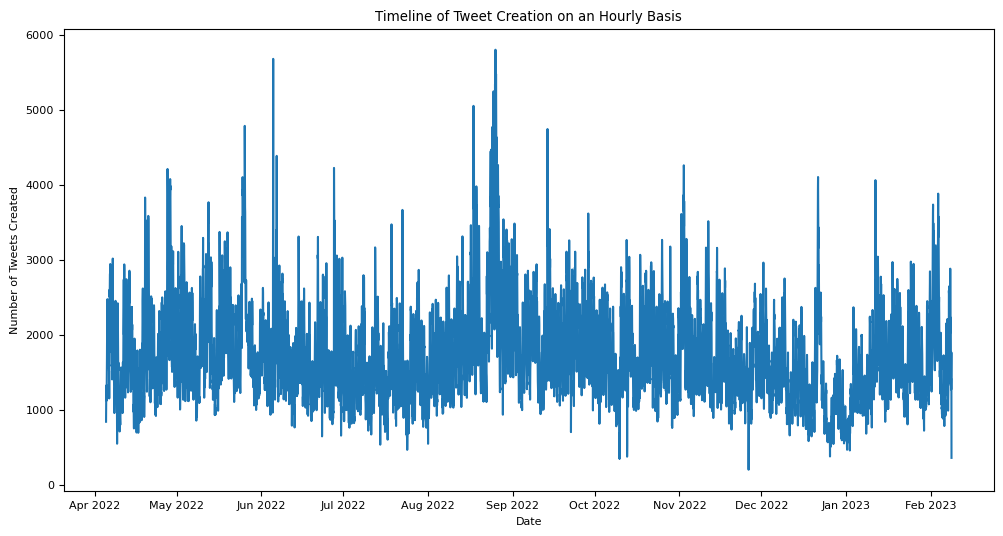

In [44]:
# Plot
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots()
ax.plot(by_hour['date'], by_hour['count'])

ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets Created')
ax.set_title('Timeline of Tweet Creation on an Hourly Basis')

# Format and change intervals of x axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.show()

## Day of Week

In [37]:
day_of_week = (dates_df.withColumn('day', f.dayofweek('tweet_date'))
                  .groupby(['day'])
                  .agg(f.count('tweet_id').alias('count'))
                  .select(['day', 'count'])
                  .toPandas())
day_of_week

,day,count
0,1,1463722
1,6,1955324
2,3,2026374
3,5,2121412
4,4,2187184
5,7,1570833
6,2,1802922


In [38]:
day_of_week.sort_values(by='day', ascending=True, inplace=True)
day_of_week

,day,count
0,1,1463722
6,2,1802922
2,3,2026374
4,4,2187184
3,5,2121412
1,6,1955324
5,7,1570833


In [39]:
# Convert to string
day_map = {
    1: 'Mon',
    2: 'Tue',
    3: 'Wed',
    4: 'Thu',
    5: 'Fri',
    6: 'Sat',
    7: 'Sun'
}
day_of_week.replace(day_map, inplace=True)
day_of_week

,day,count
0,Mon,1463722
6,Tue,1802922
2,Wed,2026374
4,Thu,2187184
3,Fri,2121412
1,Sat,1955324
5,Sun,1570833


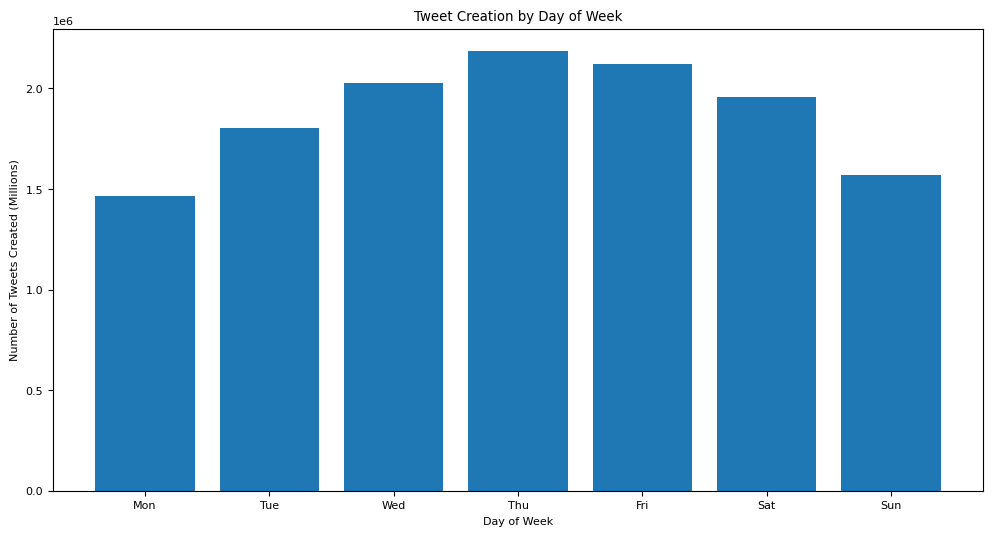

In [40]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots()
ax.bar(day_of_week['day'], day_of_week['count'])

ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Tweets Created (Millions)')
ax.set_title('Tweet Creation by Day of Week')

plt.show()